# ASL Classification with a CNN

In [2]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ggr9odso
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ggr9odso
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-cp36-none-any.whl size=82320 sha256=e189cfa4ebb1edcfb32254584062f455b156ab4904a2bee4a400d02b2e0b9b46
  Stored in directory: /tmp/pip-ephem-wheel-cache-t17_jrg3/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
#import keras

from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive


# Get reproducible results
random_state = 46
tf.random.set_seed(random_state)

Using TensorFlow backend.


## GPU configuration
If you have a GPU, enable experimental memory growth.

In [0]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

## File Paths

In [5]:
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/ECE 542/asl_alphabet_test"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
asl_alphabet_test


In [0]:
train_dir = "/content/drive/My Drive/ECE 542/asl_alphabet_train/asl_alphabet_train"
test_dir = "/content/drive/My Drive/ECE 542/asl_alphabet_test/asl_alphabet_test"

## Train model

In [0]:
def fit_model(model, train_generator, val_generator):
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    model.summary()
    
    print('Fitting model...')
    history = model.fit(train_generator, 
        steps_per_epoch=50, #50
        epochs=45, 
        verbose=1, 
        validation_data=val_generator, 
        validation_steps=10, #10
        #use_multiprocessing=True, 
        #workers=8,
        callbacks=[
                tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/ECE 542/modelVGG16_bestValAccuracy.h5', monitor='val_accuracy', save_best_only = True),
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta = 0.01, patience = 3, restore_best_weights = True)
            ])
    
    print('Evaluating model...')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    
    del model
    K.clear_session()


def fit_with_base_model(base_model, trainable = False):
    print("Defining train data generator...")
    datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=30,
        validation_split=0.30)
    
    train_generator = datagen.flow_from_directory(
        train_dir,
        subset='training',
        target_size=(200, 200),
        batch_size=128,
        class_mode='sparse'
    )
    
    val_generator = datagen.flow_from_directory(
        train_dir,
        subset='validation',
        target_size=(200, 200),
        batch_size=128,
        class_mode='sparse'
    )
    
    base_model.trainable = trainable
    fit_model(tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(29)
    ]), train_generator, val_generator)
    

# Base models

## VGG16
This model uses VGG16 as a base model initialized with the ImageNet weights.  

Found 69632 images belonging to 29 classes.
Found 17404 images belonging to 29 classes.
58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65536     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None,

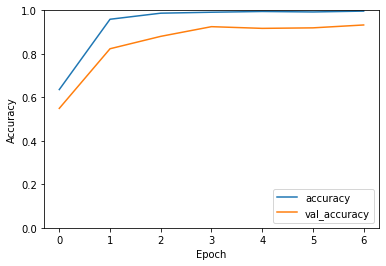

In [8]:
datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,
    featurewise_std_normalization=False,
    samplewise_center=True,
    samplewise_std_normalization=True,
    brightness_range = (0.25,1.75),
    rotation_range=20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    validation_split=0.20)

train_generator = datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(224, 224),
    batch_size=128, #128 for real
    class_mode='sparse',
    #color_mode='grayscale'
)

val_generator = datagen.flow_from_directory(
    train_dir,
    subset='validation',
    target_size=(224, 224),
    batch_size=128, #128 for real
    class_mode='sparse',
    #color_mode='grayscale'
)

base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
for layer in base_model.layers[:-3]:
            layer.trainable = False

fit_model(tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(29)
]), train_generator, val_generator)